In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Data Preparation

In [82]:
# !pip install openpyxl

df = pd.read_excel("Rodkaidee Data.xlsx", engine="openpyxl")
df.head(5)

,Brand,Model,Engine,Segment,Year,Mileage,Province,Price,Color
0,Mazda,Mazda2,1.3,B-Segment,2022.0,15640.0,กรุงเทพมหานคร,499000.0,Gray
1,Suzuki,Celerio,1.0,Eco Car,2021.0,9545.0,กรุงเทพมหานคร,315000.0,White
2,Mitsubishi,Mirage,1.2,Eco Car,2021.0,10900.0,นนทบุรี,335000.0,Gray
3,Nissan,March,1.2,Eco Car,2021.0,12000.0,กรุงเทพมหานคร,339000.0,Silver
4,Mitsubishi,Attrage,1.2,Eco Car,2021.0,25706.0,กาญจนบุรี,350000.0,Gray


Get label encoder for categorical columns (for example, column X has 3 unique, non-numeric values: 'A', 'B', 'C', so we need to encode them to 0, 1, 2)

In [83]:
def get_id_dict(dataframe, col_name):
    return {key: i for i, key in enumerate(dataframe[col_name].value_counts().keys())}

car_brand_id_dict = get_id_dict(df, "Brand")
car_model_id_dict = get_id_dict(df, "Model")
car_segment_id_dict = get_id_dict(df, "Segment")
province_id_dict = get_id_dict(df, "Province")
color_id_dict = get_id_dict(df, "Color")

engine_size_id_dict = get_id_dict(df, "Engine")

In [84]:
print(car_brand_id_dict)

{'Toyota': 0, 'Honda': 1, 'Nissan': 2, 'Mazda': 3, 'Mitsubishi': 4, 'Suzuki': 5}


Apply the label encoder to each column with categorical data

In [85]:
df["Brand"] = df["Brand"].apply(lambda x: car_brand_id_dict[x])
df["Model"] = df["Model"].apply(lambda x: car_model_id_dict[x])
df["Segment"] = df["Segment"].apply(lambda x: car_segment_id_dict[x])
df["Province"] = df["Province"].apply(lambda x: province_id_dict[x])
df["Color"] = df["Color"].apply(lambda x: color_id_dict[x])

df["Engine"] = df["Engine"].apply(lambda x: engine_size_id_dict[x])

Normalize continuous values (for example, column X has values from 0 to 1000000, so we need to normalize them to 0 to 1)

In [92]:
max_price = df["Price"].max()
df["Price"] = df["Price"].apply(lambda x: x / max_price)

In [93]:
target_column = "Price"
# Drop the target column from the dataframe.
x_df = df.drop(columns=[target_column]).reset_index(drop=True)
# Create a new dataframe with only the target column.
y_df = df[[target_column]].reset_index(drop=True)

## **Train a simple Linear Regression Model**

In [94]:
# Split the data into train and test sets.
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=42)

In [95]:
# Fit a linear regression model to the training data.
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

LinearRegression()

In [96]:
predictions = lr_model.predict(x_test)
predictions.shape

(1480, 1)

### Evaluate the model on the test set with Mean Squared Error

In [97]:
# Calculate the mean squared error.
mean_squared_error(predictions, y_test.values)

0.006451231528844747

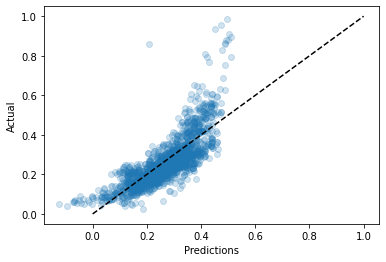

In [109]:
# Plot a perfect prediction line.
plt.plot([0, 1], [0, 1],  "--", color="black",)
# Plot the predictions vs the actual values.
plt.scatter(predictions, y_test.values, alpha=0.2)

plt.xlabel("Predictions")
plt.ylabel("Actual")
plt.show()

## **Train a simple Neural Network**

In [176]:
from torch.utils.data import Dataset, DataLoader

class CarPriceDataset(Dataset):
    def __init__(self, x_dataframe, y_dataframe):
        self.x = x_dataframe.values
        self.y = y_dataframe.values

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [195]:
train_dataset = CarPriceDataset(x_train, y_train)
test_dataset = CarPriceDataset(x_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [196]:
class CarPriceModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.linear(x)
        return out

In [197]:
model = CarPriceModel(input_size=len(x_train.columns), output_size=y_train.shape[1])
model

CarPriceModel(
  (linear): Linear(in_features=8, out_features=1, bias=True)
)

In [198]:
from tqdm.auto import tqdm
# Define the loss function and the optimizer.
learning_rate = 1e-3 # = 0.1
loss_fn = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model.
epochs = 120
update_frequency = 10

train_losses = []
test_losses = []
for epoch in tqdm(range(epochs)):
    # Set the model to training mode.
    model.train()
    for x, y in train_dataloader:
        # Forward pass.
        y_pred = model(x.float())
        # Calculate the loss.
        loss = loss_fn(y_pred, y.float())
        # Backward pass.
        loss.backward()
        # Update the model parameters.
        optimizer.step()
        # Reset the gradients.
        optimizer.zero_grad()
    # Save the training loss.
    train_losses.append(loss.item())

    # Set the model to evaluation mode and calculate the test loss at the end of each epoch.
    model.eval()
    with torch.no_grad():
        for x, y in test_dataloader:
            # Forward pass.
            y_pred = model(x.float())
            # Calculate the loss.
            loss = loss_fn(y_pred, y.float())

        # Print the loss if the epoch is a multiple of 10.
        if epoch % update_frequency == 0:
            print(f"Epoch {epoch}: {loss.item()}")

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0: 236838.34375
Epoch 10: 88500.7890625
Epoch 20: 3873.16357421875
Epoch 30: 3.506937265396118
Epoch 40: 1.248306393623352
Epoch 50: 0.49693742394447327
Epoch 60: 0.11335849016904831
Epoch 70: 0.06989189982414246
Epoch 80: 18.913785934448242
Epoch 90: 0.013194456696510315
Epoch 100: 0.03054680861532688
Epoch 110: 0.05981767922639847


### Evaluate the model on the test set with Mean Squared Error

In [199]:
# Get the predictions for the test set.
model.eval()

prediction_list = []
actual_y_list = []
for x, y in test_dataloader:
    y_pred = model(x.float())
    prediction = y_pred.detach().numpy()
    y = y.numpy()
    prediction_list.append(prediction)
    actual_y_list.append(y)

In [200]:
actual_y_array = np.concatenate(actual_y_list)
prediction_array = np.concatenate(prediction_list)
mean_squared_error(prediction_array, actual_y_array)

0.03970055401991829

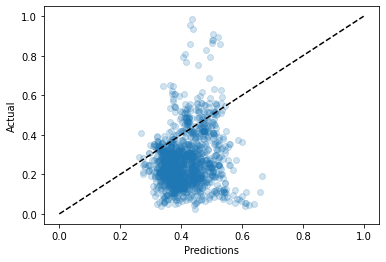

In [201]:
# Plot a perfect prediction line.
plt.plot([0, 1], [0, 1],  "--", color="black",)
# Plot the predictions vs the actual values.
plt.scatter(prediction_array, actual_y_array, alpha=0.2)

plt.xlabel("Predictions")
plt.ylabel("Actual")
plt.show()

### Use the model to predict on new data